In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv")
df=data.copy()

### EDA

* Load the data.
* Look at the `median_house_value` variable. Does it have a long tail? 

In [7]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
df.median_house_value

0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 20640, dtype: float64

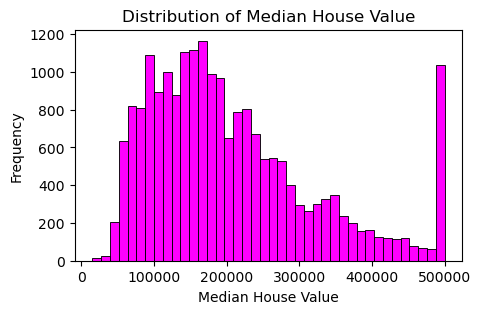

In [12]:
# eda: plot median_house_value 
plt.figure(figsize=(5,3))
sns.histplot(df.median_house_value, bins=40, color='magenta', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Median House Value')
plt.title('Distribution of Median House Value')
plt.show()

### Preparing the dataset 

For this homework, we only want to use a subset of data. 

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

Next, use only the following columns:

* `'latitude'`,
* `'longitude'`,
* `'housing_median_age'`,
* `'total_rooms'`,
* `'total_bedrooms'`,
* `'population'`,
* `'households'`,
* `'median_income'`,
* `'median_house_value'`

In [13]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [14]:
df["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [15]:
temp = df.loc[(df["ocean_proximity"] == '<1H OCEAN') | (df["ocean_proximity"] == 'INLAND')]
temp.ocean_proximity.value_counts()

ocean_proximity
<1H OCEAN    9136
INLAND       6551
Name: count, dtype: int64

### Question 1

There's one feature with missing values. What is it?

* `total_rooms`
* `total_bedrooms`
* `population`
* `households`

In [16]:
temp.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

### Question 2

What's the median (50% percentile) for variable `'population'`?

- 995
- 1095
- 1195
- 1295

In [17]:
temp.population.median()

1195.0

### Prepare and split the dataset

* Shuffle the initial dataset, use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Apply the log transformation to the `median_house_value` variable using the `np.log1p()` function.

In [18]:
np.random.seed(42)
n = len(temp)
idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]
val_ = int(0.2*n)
test_= int(0.2*n)
train_= n-(val_ + test_)

df_train=df_shuffled.iloc[:train_].copy().copy()
df_val=df_shuffled.iloc[train_:train_+val_].copy()
df_test=df_shuffled.iloc[train_+val_:].copy()

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

### Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

Options:

- With 0
- With mean
- Both are equally good


In [19]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error**2).mean()
    return np.sqrt(mse)

base = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
    'total_bedrooms', 'population', 'households', 'median_income']

def prepare_X(df, value):
    df_num = df[base]
    df_num = df_num.fillna(value)
    X = df_num.values
    return X 

def prepare_train_eval(train_X, train_y, val_X, val_y, fillna_value=0):
    X_train = prepare_X(train_X, fillna_value)
    X_val = prepare_X(val_X, fillna_value)
    w_0, w = train_linear_regression(X_train, train_y)
    y_pred = w_0 + X_val.dot(w)
    return round(rmse(val_y, y_pred),2)

In [20]:
rmse_0 = prepare_train_eval(df_train, y_train, df_val, y_val, 0)
rmse_mean = prepare_train_eval(df_train, y_train, df_val, y_val, df_train['total_bedrooms'].mean())
rmse_0, rmse_mean # Both are equally good

(0.34, 0.34)

### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

Options:

- 0
- 0.000001
- 0.001
- 0.0001

In [22]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye((XTX.shape[0]))
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

X_train=prepare_X(df_train, 0)
X_val=prepare_X(df_val, 0)

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%7s' %r, round(rmse(y_val, y_pred), 2))

      0 0.34
  1e-06 0.34
 0.0001 0.34
  0.001 0.34
   0.01 0.34
    0.1 0.34
      1 0.35
      5 0.35
     10 0.35


### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

What's the value of std?

- 0.5
- 0.05
- 0.005
- 0.0005

> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.


In [23]:
def shuffle(s, df):
    n = len(df)
    idx = np.arange(n)
    np.random.seed(s)
    np.random.shuffle(idx)
    df_shuffled = df.iloc[idx]
    return df_shuffled

def split(df_shuffled, train_, val_, test_):
    df_train=df_shuffled.iloc[:train_].copy()
    df_val=df_shuffled.iloc[train_:train_+val_].copy()
    df_test=df_shuffled.iloc[train_+val_:].copy()
    
    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)
    
    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']

    return [df_train, y_train], [df_val, y_val], [df_test, y_test]

def shuffle_split(s, df):
    df_shuffled = shuffle(s, df)
    return split(df_shuffled, train_, val_, test_)

#######
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_values = []

for seed in seed_values:
    train_df, val_df, test_df = shuffle_split(seed,df)
    # fill with 0
    X_train = prepare_X(train_df[0], 0)
    X_val = prepare_X(val_df[0], 0)
    w_0, w = train_linear_regression(X_train, train_df[1])
    y_pred = w_0 + X_val.dot(w)
    rmse_values.append(rmse(val_df[1], y_pred))

pd.concat([
    pd.Series(seed_values, name='seeds'),
    pd.Series(rmse_values, name='rmse')], axis=1)

,seeds,rmse
0,0,0.345378
1,1,0.341345
2,2,0.345312
3,3,0.359117
4,4,0.341620
5,5,0.346069
6,6,0.334860
7,7,0.343257
8,8,0.337872
9,9,0.345337


In [24]:
np.round(np.std(rmse_values), 3)

0.006

### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

Options:

- 0.13
- 0.23
- 0.33
- 0.43

In [37]:
seed = 9
train_df, val_df, test_df = shuffle_split(seed,df)

df_train = pd.concat([train_df[0], val_df[0]]).reset_index()
df_test = test_df[0]

y_train = np.concatenate([train_df[1],val_df[1]])
y_test = test_df[1]

X_train = prepare_X(df_train, 0)
X_test = prepare_X(df_test, 0)

w_0, w = train_linear_regression_reg(X_train, y_train, r=0.001)
y_pred = w_0 + X_test.dot(w)

np.round(rmse(y_test, y_pred), 2)

0.34